In [50]:
# Imports
import matplotlib.pyplot as plt
plt.style.use('plot_style.mplstyle')
import yaml
import numpy as np
import pingouin as pg
import pandas as pd

# Custom functions
from functions.dataloaders import load_data
from functions.signal_processing import preprocess_data
# Params
with open('params.yaml','r') as file:
    params = yaml.full_load(file)

# Plot footprints and calcium traces with associated colors

In [89]:
from umap.umap_ import UMAP
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr as corr
from functions.dataloaders import load_data
from functions.signal_processing import preprocess_data
from functions.analysis import reconstruction_binary_accuracy
from functions.plotting import plot_embedding_results

#%% Load parameters
with open('params.yaml','r') as file:
    params = yaml.full_load(file)

#%% Load session
session_path = '../../datasets/calcium_imaging/M246/M246_LT_6'
data = load_data(session_path)
data = preprocess_data(data,params)

np.random.seed(params['seed'])
trainingFrames = np.zeros(len(data['caTime']), dtype=bool)

if params['train_set_selection']=='random':
    trainingFrames[np.random.choice(np.arange(len(data['caTime'])), size=int(len(data['caTime'])*params['train_test_ratio']), replace=False)] = True
elif params['train_set_selection']=='split':
    trainingFrames[0:int(params['train_test_ratio']*len(data['caTime']))] = True 
data['trainingFrames']=trainingFrames

embedding_model = UMAP(n_components=params['embedding_dims'],
                       n_neighbors=params['n_neighbors'],
                       min_dist=params['min_dist'],
                       metric=('euclidean'),
                       random_state=42).fit(data['neuralData'][data['trainingFrames'],0:params['input_neurons']])

train_embedding = embedding_model.transform(data['neuralData'][data['trainingFrames'],0:params['input_neurons']])
test_embedding = embedding_model.transform(data['neuralData'][~data['trainingFrames'],0:params['input_neurons']])

train_reconstruction = embedding_model.inverse_transform(train_embedding)
test_reconstruction = embedding_model.inverse_transform(test_embedding)

train_stats = corr(data['neuralData'][data['trainingFrames'],0:params['input_neurons']].flatten(),train_reconstruction.flatten())
test_stats = corr(data['neuralData'][~data['trainingFrames'],0:params['input_neurons']].flatten(),test_reconstruction.flatten())

# train_accuracy, train_precision, train_recall, train_F1 = reconstruction_binary_accuracy(train_reconstruction, data['procData'][data['trainingFrames'],0:params['input_neurons']])
# test_accuracy, test_precision, test_recall, reconstruction_stats = reconstruction_binary_accuracy(test_reconstruction, data['procData'][~data['trainingFrames'],0:params['input_neurons']])
# print(f'Train F1: {np.mean(train_F1).round(4)}, Test F1: {np.mean(reconstruction_stats).round(4)}')

pos_decoder = LinearRegression().fit(train_embedding, data['position'][data['trainingFrames'],:])
score=pos_decoder.score(test_embedding, data['position'][~data['trainingFrames'],:])
train_pred_pos = pos_decoder.predict(train_embedding)
test_pred_pos = pos_decoder.predict(test_embedding)

train_pred_pos_stats = corr(train_pred_pos.flatten(),data['position'][data['trainingFrames'],:].flatten())
test_pred_pos_stats = corr(test_pred_pos.flatten(),data['position'][~data['trainingFrames'],:].flatten())

full_embedding = embedding_model.transform(data['neuralData'][:,0:params['input_neurons']])
full_reconstruction = embedding_model.inverse_transform(full_embedding)
pred_position = pos_decoder.predict(full_embedding)

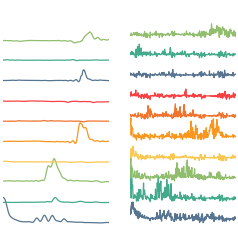

In [165]:
# Plot embedding results
plt.figure(figsize=(1,1))
cells2plot = 10
plt.subplot(121)
for i in range(cells2plot):
    plt.plot(data['caTime'],data['neuralData'][:,i]*params['plot_gain']+i,
#            c=(0,0,0),
            linewidth=.3)
plt.xlim(50,60)
plt.axis('off')

plt.subplot(122)
for i in range(cells2plot):
    plt.plot(data['caTime'],full_reconstruction[:,i]*params['plot_gain']+i,
#            c=(.8,0,0),
            linewidth=.3)
plt.xlim(50,60)
plt.axis('off')

#plt.tight_layout()
plt.savefig('results/figures/fig1/example_reconstruction.pdf')

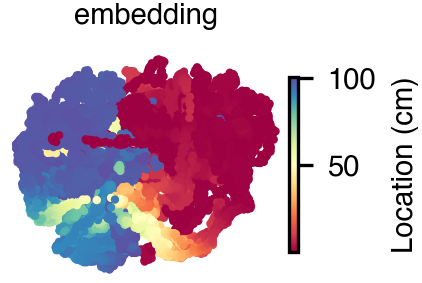

In [180]:
#plt.figure(figsize=(1.5,1))
plt.scatter(full_embedding[:,0],full_embedding[:,1],c=data['position'][:,0], cmap='Spectral', s=1)
plt.title('embedding')
#plt.xlabel('$D_{1}$')
#plt.ylabel('$D_{2}$')
plt.axis('scaled')
plt.axis('off')
plt.colorbar(label='Location (cm)', fraction=0.025, pad=.001)

#plt.tight_layout()
plt.savefig('results/figures/fig1/example_embedding.png')

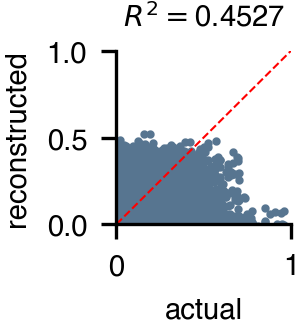

In [189]:
plt.figure(figsize=(.75,.75))
plt.scatter(data['neuralData'][:,0:params['input_neurons']].flatten(), full_reconstruction.flatten(), s=1)
plt.plot([0,1],[0,1],'r--')
plt.title(f'$R^2=${test_stats[0].round(4)}')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('actual')
plt.ylabel('reconstructed')

plt.savefig('results/figures/fig1/example_recon_score.png')

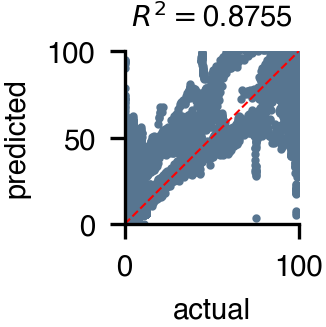

In [188]:
plt.figure(figsize=(.75,.75))
plt.scatter(data['position'].flatten(),pred_position.flatten(), s=1)
plt.plot([0,100],[0,100],'r--')
plt.xlim([0,100])
plt.ylim([0,100])
plt.title(f'$R^2=${test_pred_pos_stats[0].round(4)}')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.savefig('results/figures/fig1/example_decoding_score.png')

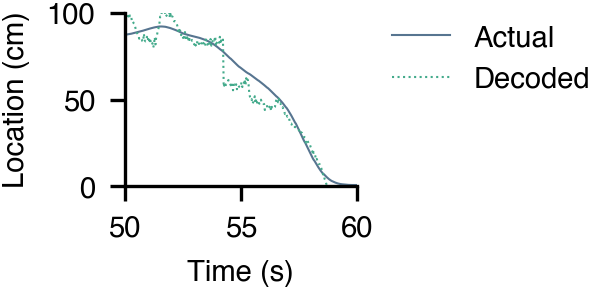

In [195]:
plt.figure(figsize=(1,.75))
plt.plot(data['caTime'],data['position'][:,0], label='Actual')
plt.plot(data['caTime'],pred_position[:,0], label='Decoded', linestyle=':')
plt.xlim([50,60])
plt.ylim([0,100])
plt.xlabel('Time (s)')
plt.ylabel('Location (cm)')
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0)

#plt.tight_layout()
plt.savefig('results/figures/fig1/example_decoded_loc.pdf')
    